In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q ultralytics torch torchvision tqdm lxml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00


In [16]:

# 🔹 Import required libraries
import os
import shutil
import torch
import xml.etree.ElementTree as ET
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO
from PIL import Image

# 🔹 Device check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Using device: {device}")

# 🔹 Download Pascal VOC dataset
dataset = torchvision.datasets.VOCDetection(root=".", year="2012", image_set="train", download=True)

# 🔹 Define paths
voc_path = "./VOCdevkit/VOC2012"
output_path = "./dataset"
os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)

# 🔹 Define Pascal VOC classes
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
           'dog', 'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

# 🔹 XML to YOLO conversion function
def convert_annotation(xml_file, txt_file, img_size):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            dw = 1.0 / img_size[0]
            dh = 1.0 / img_size[1]
            x = (xmin + xmax) / 2.0 * dw
            y = (ymin + ymax) / 2.0 * dh
            w = (xmax - xmin) * dw
            h = (ymax - ymin) * dh
            f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

def process_split(split_name):
    ids_path = os.path.join(voc_path, 'ImageSets/Main', f'{split_name}.txt')
    with open(ids_path) as f:
        ids = [line.strip() for line in f.readlines()]
    for id_ in tqdm(ids, desc=f"🔁 Processing {split_name}"):
        img_file = os.path.join(voc_path, 'JPEGImages', f'{id_}.jpg')
        xml_file = os.path.join(voc_path, 'Annotations', f'{id_}.xml')
        out_img = os.path.join(output_path, f'images/{split_name}', f'{id_}.jpg')
        out_lbl = os.path.join(output_path, f'labels/{split_name}', f'{id_}.txt')
        shutil.copy(img_file, out_img)
        with Image.open(img_file) as img:
            width, height = img.size
        convert_annotation(xml_file, out_lbl, (width, height))

process_split("train")
process_split("val")


yaml_text = """\
path: ./dataset
train: images/train
val: images/val
names:
""" + "\n".join([f"  {i}: {name}" for i, name in enumerate(classes)])

with open("voc.yaml", "w") as f:
    f.write(yaml_text)

model = YOLO("yolov8n.pt")  # You can also use yolov8m.pt or yolov8n.pt

model.train(
    data="voc.yaml",
    epochs=30,
    imgsz=416,
    batch=8,
    lr0=0.002,
    optimizer="SGD",
    weight_decay=0.0001,
    warmup_epochs=1,
    patience=5,
    cos_lr=True,
    hsv_h=0,
    hsv_s=0,
    hsv_v=0,
    degrees=0,
    translate=0,
    scale=0.1,
    shear=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,
    workers=2,
    project="/content/drive/MyDrive/yolov8_runs",
    name="voc_one_phase",
    device=0
)


✅ Using device: cuda


🔁 Processing val: 100%|██████████| 5823/5823 [00:14<00:00, 397.58it/s]


100%|██████████| 6.25M/6.25M [00:00<00:00, 261MB/s]

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=voc.yaml, degrees=0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0, hsv_s=0, hsv_v=0, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_one_phase3, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, projec

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/dataset/labels/train.cache... 5717 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5717/5717 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 373.8±233.8 MB/s, size: 99.9 KB)


val: Scanning /content/dataset/labels/val.cache... 5823 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5823/5823 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/yolov8_runs/voc_one_phase3/labels.jpg... 
optimizer: SGD(lr=0.002, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolov8_runs/voc_one_phase3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.771G      1.029      3.394      1.217         26        416: 100%|██████████| 715/715 [01:27<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.81it/s]


                   all       5823      15787      0.586      0.307      0.368      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.846G      1.131       2.33       1.28         28        416: 100%|██████████| 715/715 [01:21<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.26it/s]


                   all       5823      15787      0.622      0.501       0.53      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.846G      1.112      2.078      1.269         17        416: 100%|██████████| 715/715 [01:21<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.16it/s]


                   all       5823      15787      0.657      0.541      0.584      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.846G      1.083      1.972      1.256         22        416: 100%|██████████| 715/715 [01:23<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.15it/s]


                   all       5823      15787      0.678      0.548      0.596      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.846G      1.078      1.915      1.257         24        416: 100%|██████████| 715/715 [01:22<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.81it/s]


                   all       5823      15787      0.684      0.558      0.604      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.846G       1.06      1.841      1.251         21        416: 100%|██████████| 715/715 [01:24<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.12it/s]


                   all       5823      15787      0.673      0.574      0.609      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.846G      1.051      1.791      1.245         27        416: 100%|██████████| 715/715 [01:23<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.19it/s]


                   all       5823      15787       0.69      0.565      0.614      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.846G      1.038      1.755       1.24         43        416: 100%|██████████| 715/715 [01:21<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.89it/s]


                   all       5823      15787      0.695      0.579      0.627      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.846G      1.021      1.716      1.229         38        416: 100%|██████████| 715/715 [01:24<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.14it/s]


                   all       5823      15787      0.685      0.574      0.619       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.846G      1.017      1.677      1.224         38        416: 100%|██████████| 715/715 [01:23<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  8.09it/s]


                   all       5823      15787      0.717      0.577       0.64      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.857G      1.009      1.653      1.219         26        416: 100%|██████████| 715/715 [01:24<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  7.94it/s]


                   all       5823      15787      0.696      0.585      0.636      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.857G     0.9955      1.603      1.206         26        416: 100%|██████████| 715/715 [01:23<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.12it/s]


                   all       5823      15787      0.705      0.586       0.64      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.857G     0.9742      1.578      1.199         27        416: 100%|██████████| 715/715 [01:23<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.23it/s]


                   all       5823      15787      0.719      0.595      0.649      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.857G     0.9701      1.551      1.198         29        416: 100%|██████████| 715/715 [01:21<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.18it/s]


                   all       5823      15787       0.73      0.596      0.656      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.857G     0.9547       1.51      1.185         23        416: 100%|██████████| 715/715 [01:23<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.09it/s]


                   all       5823      15787      0.714      0.611       0.66      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.857G      0.942      1.482      1.179         22        416: 100%|██████████| 715/715 [01:21<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.20it/s]


                   all       5823      15787      0.718       0.61      0.661      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.857G     0.9287      1.466      1.179         26        416: 100%|██████████| 715/715 [01:21<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.23it/s]


                   all       5823      15787      0.742       0.61      0.669      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.857G     0.9326      1.451      1.171         24        416: 100%|██████████| 715/715 [01:22<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 148/364 [00:17<00:28,  7.64it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb9803f6a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7

                   all       5823      15787      0.755      0.604      0.677      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.857G     0.9118      1.412      1.163         18        416: 100%|██████████| 715/715 [01:23<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 285/364 [00:34<00:11,  6.83it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb9803f6a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7

                   all       5823      15787      0.737       0.62      0.676       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.857G     0.9116      1.391      1.158         37        416: 100%|██████████| 715/715 [01:23<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:43<00:00,  8.29it/s]


                   all       5823      15787      0.739      0.624      0.681      0.494
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.857G     0.8352      1.296       1.05         14        416: 100%|██████████| 715/715 [01:21<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.15it/s]


                   all       5823      15787      0.732      0.618      0.674       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.883G     0.7999      1.216      1.032         20        416: 100%|██████████| 715/715 [01:20<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  7.96it/s]


                   all       5823      15787      0.752      0.609      0.675       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.883G     0.7835      1.172      1.026         17        416: 100%|██████████| 715/715 [01:20<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  8.00it/s]


                   all       5823      15787       0.75      0.614      0.677      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.883G     0.7703      1.145      1.015         26        416: 100%|██████████| 715/715 [01:20<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  8.03it/s]


                   all       5823      15787      0.734      0.626       0.68      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.883G     0.7603      1.123      1.008         14        416: 100%|██████████| 715/715 [01:19<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:44<00:00,  8.09it/s]


                   all       5823      15787      0.749      0.627      0.685        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.883G     0.7488      1.111          1         19        416: 100%|██████████| 715/715 [01:20<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.91it/s]


                   all       5823      15787      0.746      0.628      0.686        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.883G     0.7402      1.093     0.9972         10        416: 100%|██████████| 715/715 [01:19<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.88it/s]


                   all       5823      15787      0.753      0.625      0.688      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.883G     0.7295       1.08     0.9909         11        416: 100%|██████████| 715/715 [01:19<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.88it/s]


                   all       5823      15787      0.741      0.638      0.689      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.883G     0.7334      1.072     0.9911         26        416: 100%|██████████| 715/715 [01:21<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  7.99it/s]


                   all       5823      15787      0.747      0.632       0.69      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.883G     0.7271      1.068     0.9898         11        416: 100%|██████████| 715/715 [01:20<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:45<00:00,  7.93it/s]


                   all       5823      15787      0.743      0.635       0.69      0.504

30 epochs completed in 1.082 hours.
Optimizer stripped from /content/drive/MyDrive/yolov8_runs/voc_one_phase3/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/yolov8_runs/voc_one_phase3/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/yolov8_runs/voc_one_phase3/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [00:46<00:00,  7.86it/s]


                   all       5823      15787      0.744      0.635       0.69      0.504
             aeroplane        348        484      0.848      0.698      0.769      0.602
               bicycle        290        380      0.822      0.666      0.757       0.55
                  bird        374        629      0.775      0.579      0.644      0.437
                  boat        252        491      0.585       0.47        0.5       0.28
                bottle        369        733      0.724       0.44      0.513      0.353
                   bus        211        320      0.825      0.744      0.807      0.687
                   car        608       1173      0.833      0.601      0.701      0.502
                   cat        544        618       0.81      0.786      0.852      0.698
                 chair        642       1449      0.622        0.5      0.541      0.359
                   cow        154        347      0.585      0.689      0.648       0.45
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb8e5bc5110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

<ipython-input-17-981d7c5e6978>:39: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-981d7c5e6978>:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


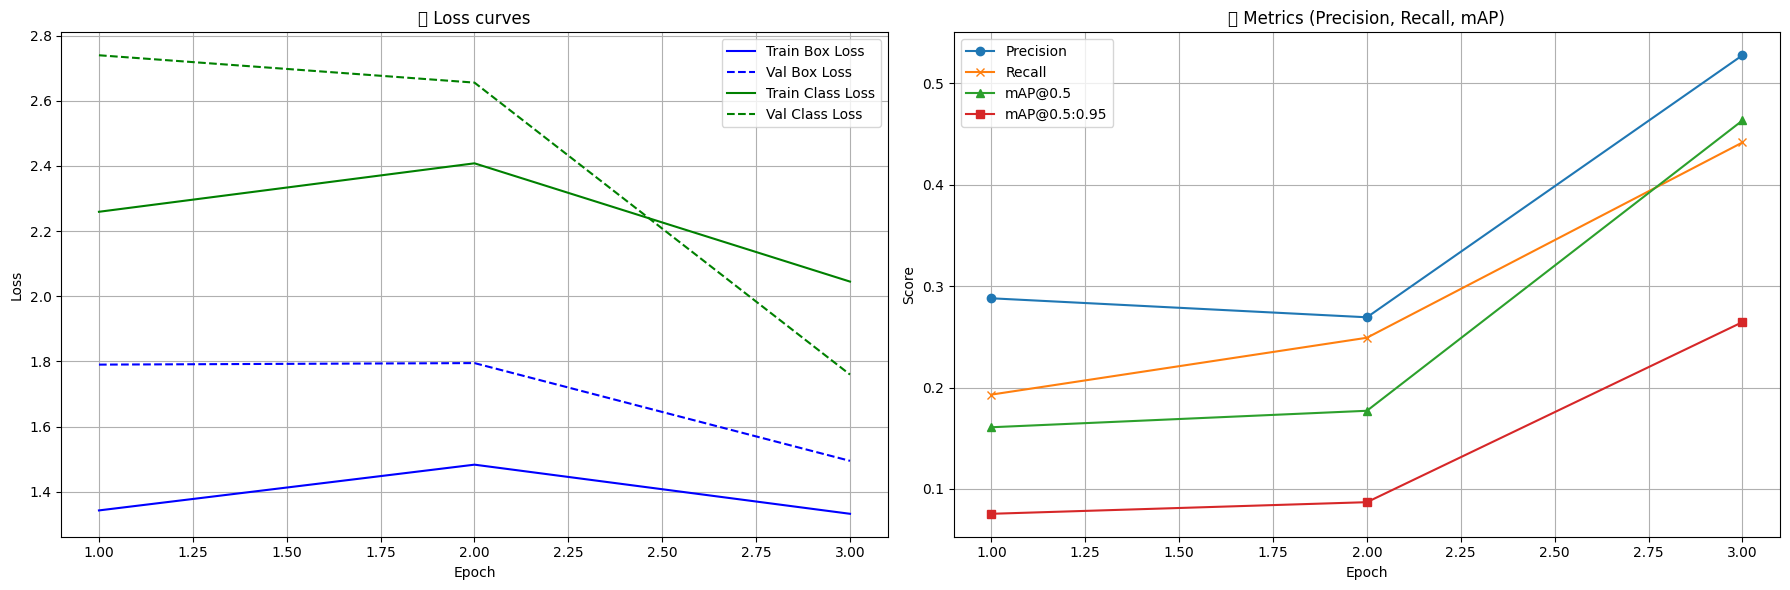

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

results_csv_path = "/content/drive/MyDrive/yolov8_runs/voc_one_phase2/results.csv"

assert os.path.exists(results_csv_path), " results.csv չգտնվեց: Ստուգիր մոդելի train path-ը։"

results = pd.read_csv(results_csv_path)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 📉 Loss curves
axs[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', color='blue')
axs[0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', linestyle='--', color='blue')
axs[0].plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss', color='green')
axs[0].plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', linestyle='--', color='green')
axs[0].set_title("📉 Loss curves")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# 📈 mAP and precision
axs[1].plot(results['epoch'], results['metrics/precision(B)'], label='Precision', marker='o')
axs[1].plot(results['epoch'], results['metrics/recall(B)'], label='Recall', marker='x')
axs[1].plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP@0.5', marker='^')
axs[1].plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', marker='s')
axs[1].set_title("📈 Metrics (Precision, Recall, mAP)")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Save best model
model_path = "/content/drive/MyDrive/yolov8_runs/voc_one_phase2/best.pt"
model.save(model_path)

# Inference Example
image_path = "/content/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg"
model.predict(image_path, save=True, imgsz=640, conf=0.5)

print("✅ Training Complete!.")



image 1/1 /content/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg: 384x640 1 aeroplane, 1 person, 43.9ms
Speed: 2.0ms preprocess, 43.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/drive/MyDrive/yolov8_runs/voc_one_phase22
✅ Training Complete!.
